# Notebook for looking at photon yield / percentage for diff theta, phi

In [1]:
#imports
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
from scipy.stats import norm
from scipy.optimize import curve_fit
import sympy
from IPython.display import clear_output
import math
import time
import util
#My imports
from util import PVect,get_layer,create_layer_map,theta_func,phi_func,findBin,bin_percent_theta_phi
import os

Using device cuda:0


## Use this for single files

In [16]:
particle = "mu"
energy = "5"
color_dict = {
    "pi" : "red",
    "mu" : "blue"
}

#full sector test
# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/July_16/optph_full_sector/mu_5GeV_10events_theta_90.edm4hep.root:events"


#Used to fit curve
# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_13/variation/full_{particle}_{energy}GeV_10k.edm4hep.root:events"

# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_14/variation/full_{particle}_{energy}GeV_1000.edm4hep.root:events"
# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_13/one_sector/pi_5GeV_2k.edm4hep.root:events"
# events = up.open(uproot_path)

x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
Pathlength_branch = events["HcalBarrelHits.pathLength"].array(library='np')
Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
MC_parents = events["_MCParticles_parents.index"].array(library='np')
MC_daughters = events["MCParticles.daughters_end"].array(library='np')
PDG_branch = events["MCParticles.PDG"].array(library='np')
MC_endpoint_x_branch = events["MCParticles.endpoint.x"].array(library='np')

time_branch = events["HcalBarrelHits.time"].array(library='np')
layer_map = [1830.8000, 1841.4000, 1907.5, 1918.1,1984.1999, 1994.8000, 2060.8999,2071.5,2137.6001,2148.1999,2214.3000,2224.8999,2291,2301.6001,2367.6999,2378.3000,2444.3999,2455,2521.1001,2531.6999,2597.8000,2608.3999,2674.5,2685.1001,2751.1999,2761.8000,2827.8999,2838.5]    

MC_px = events["MCParticles.momentum.x"].array(library='np')
MC_py = events["MCParticles.momentum.y"].array(library='np')
MC_pz = events["MCParticles.momentum.z"].array(library='np')
MC_m = events["MCParticles.mass"].array(library='np')
MC_vertex_x = events["MCParticles.vertex.x"].array(library='np')

## Use this for multiple files

In [2]:
branch_list = ["HcalBarrelHits.position.x","HcalBarrelHits.EDep","HcalBarrelHits.pathLength","_HcalBarrelHits_MCParticle.index","_MCParticles_parents.index","MCParticles.daughters_end","MCParticles.PDG","MCParticles.endpoint.x","MCParticles.momentum.x","MCParticles.momentum.y","MCParticles.momentum.z","MCParticles.mass","MCParticles.vertex.x","HcalBarrelHits.time"]
file_dir = f"/cwork/rck32/eic/work_eic/root_files/July_16/test/"
# num_files = len([name for name in os.listdir(file_dir) if not os.path.isdir(name)])
# file_names = [name for name in os.listdir(file_dir) if not os.path.isdir(name)]
tree_ext = ":events"
events = up.concatenate(file_dir + "*" + tree_ext)


# for i in range(num_files):
#     if(i == 0):
#         events = up.open(file_dir + file_names[i] + tree_ext).arrays(branch_list,library="np")
#     else:
#         if(i > 0):
#             break
#         events = pd.concat([events,up.open(file_dir + file_names[i] + tree_ext).arrays(branch_list,library="np")],ignore_index = True)


In [13]:
x_pos_branch = events["HcalBarrelHits.position.x"]
EDep_branch = events["HcalBarrelHits.EDep"]
Pathlength_branch = events["HcalBarrelHits.pathLength"]
Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"]
MC_parents = events["_MCParticles_parents.index"]
MC_daughters = events["MCParticles.daughters_end"]
PDG_branch = events["MCParticles.PDG"]
MC_endpoint_x_branch = events["MCParticles.endpoint.x"]

time_branch = events["HcalBarrelHits.time"]

MC_px = events["MCParticles.momentum.x"]
MC_py = events["MCParticles.momentum.y"]
MC_pz = events["MCParticles.momentum.z"]
MC_m = events["MCParticles.mass"]
MC_vertex_x = events["MCParticles.vertex.x"]

Idea: first find which super layer, then from there test if in first or second layer

In [14]:
layer_map,super_layer_map = create_layer_map()

# % photons as function of z hit pos

In [28]:
num_events = len(EDep_branch)

pixels_per_event = np.zeros(num_events)

PDG_per_event = np.zeros(num_events)

times = []

break_val = 10
begin_time = time.time()
for event_idx in range(len(EDep_branch)):
    if(event_idx > break_val):
        break
    if(not (event_idx % (break_val / 100))):
        clear_output(wait = True)
        print(f"{event_idx / (break_val / 100)}% done")
    num_MC = 0
    for i in range(len(PDG_branch[event_idx])):
        if(PDG_branch[event_idx][i] == -22):
            PDG_per_event[event_idx]+=1
    for hit in range(len(EDep_branch[event_idx])):
        #check if hit is from optph
        if(PDG_branch[event_idx][Hits_MC_idx_branch[event_idx][hit]] == -22):
            pixels_per_event[event_idx]+=1
            times.append(time_branch[event_idx][hit])
end_time = time.time()
print(f"took {(end_time - begin_time) / 60} minutes")

0.0% done
took 1692561153.1719387 minutes


In [29]:
sum(pixels_per_event) / sum(PDG_per_event)

0.1826196738171815

In [34]:
len(times)

1390670

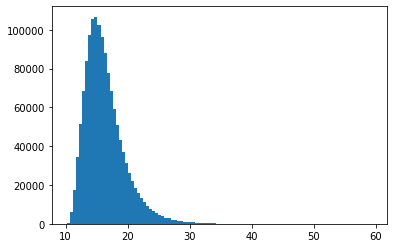

In [35]:
plot.hist(times,bins = 100);

In [ ]:
pixels_per_event.mean()

In [28]:
MC_pps = 100000 / 55 #pixels per second
NF_pps = 74000 / 1
print(f"rate of sim: {MC_pps} | rate of NF: {NF_pps}")

rate of sim: 1818.1818181818182 | rate of NF: 74000.0


In [9]:
z_bin_centers = np.empty(n_bins)
for i in range(len(z_bins) - 1):
    z_bin_centers[i] = (z_bins[i] + z_bins[i+1]) / 2
z_bin_centers_dis = 770 - z_bin_centers    

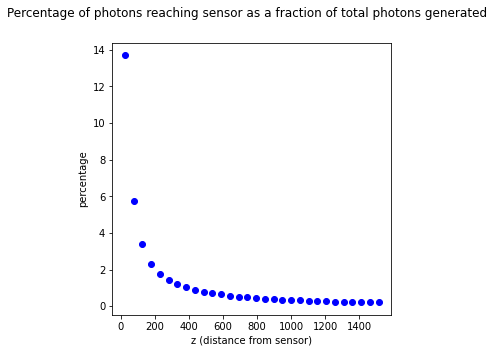

In [10]:
fig, ax1 = plot.subplots(1,1, figsize=(5,5))
fig.suptitle("Percentage of photons reaching sensor as a fraction of total photons generated")
ax1.set_ylabel("percentage")
ax1.scatter(z_bin_centers_dis,z_percent,color = "blue")
ax1.set_xlabel("z (distance from sensor)")
fig.show()
# fig.savefig("plots/percentage/June_14_mu_5GeV_10k_phi_theta_20_bins.jpeg")

In [14]:
def inverse(x,a,b,c):
    return a  / (x + b) + c

In [15]:
fit_percent = []
fit_bins = []
for i in range(n_bins):
    if(np.isnan(z_percent[i])):
        continue
    fit_percent.append(z_percent[i])
    fit_bins.append(z_bin_centers_dis[i])

In [16]:
popt_z, pcov_z = curve_fit(inverse,fit_bins,fit_percent)
fit_x = np.linspace(25,1500,200)
# z_fit = inverse(fit_x,*popt_z)
z_fit = inverse(fit_x,494.98,9.9733,-0.16796)

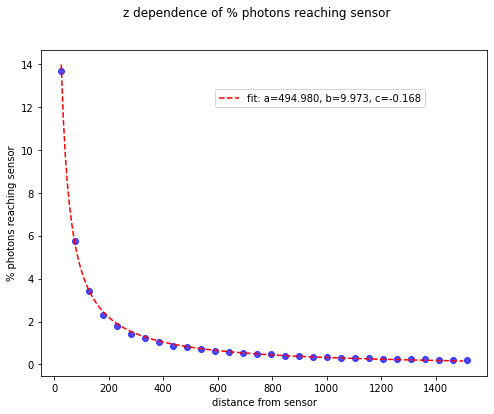

In [37]:
fig_z, ax_z = plot.subplots(1,1, figsize = (8,6))
ax_z.plot(fit_x,z_fit, 'r--',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_z))
fig_z.suptitle("z dependence of % photons reaching sensor")
ax_z.scatter(fit_bins,fit_percent,color="blue", alpha = 0.7)
ax_z.set_xlabel("distance from sensor")
ax_z.set_ylabel("% photons reaching sensor")
fig_z.legend(bbox_to_anchor=(0.8, 0.8))

In [18]:
popt_z

array([ 4.94980435e+02,  9.97331864e+00, -1.67969893e-01])